In [1]:
import matplotlib.pyplot as plt
import numpy as np
import heptools as ht
import mplhep as hep
import pandas as pd

In [2]:
signal = pd.read_parquet("data/analysis_Signal.parquet")
bkg1   = pd.read_parquet("data/analysis_Bkg1.parquet")
bkg2   = pd.read_parquet("data/analysis_Bkg2.parquet")
bkg3   = pd.read_parquet("data/analysis_Bkg3.parquet")
bkg4   = pd.read_parquet("data/analysis_Bkg4.parquet")

In [3]:
# signal.head()
bkg1.head()
# bkg2.head()
# bkg3.head()
# bkg4.head(10)

,W_mass,BB_mass,BBA_mass,Njet,dB_delta_r,dB_delta_eta,dB_delta_phi,bP_delta_r,photon_energy
0,65.265434,364.265808,487.556976,6,2.859712,0.805317,2.743979,1.784778,217.698364
1,62.874870,179.025650,278.387421,5,3.117490,1.211693,2.872376,3.158884,137.015564
2,13.891640,395.341339,414.735016,5,4.212399,3.195894,2.744187,3.543407,18.523125
3,63.467663,101.626961,156.027618,5,1.373968,0.529327,1.267912,2.865249,18.952227
4,406.822784,344.579620,1022.235901,4,1.820052,1.049113,1.487263,3.040561,478.602203


In [4]:
signal_info= ht.HEPExp()
signal_info.set_LHC(run='HL-LHC')
signal_info.set_xsec(0.01142, 'pb')
signal_info.set_simulation(500000)
bkg1_info = ht.HEPExp()
bkg1_info.set_LHC(run='HL-LHC')
bkg1_info.set_xsec(2.073, 'pb')
bkg1_info.set_simulation(100000)
bkg2_info = ht.HEPExp()
bkg2_info.set_LHC(run='HL-LHC')
bkg2_info.set_xsec(0.315, 'pb')
bkg2_info.set_simulation(100000)
bkg3_info = ht.HEPExp()
bkg3_info.set_LHC(run='HL-LHC')
bkg3_info.set_xsec(116.2, 'pb')
bkg3_info.set_simulation(100000)
bkg4_info = ht.HEPExp()
bkg4_info.set_LHC(run='HL-LHC')
bkg4_info.set_xsec(0.3564, 'pb')
bkg4_info.set_simulation(100000)

In [5]:
lumi=[
signal_info.get_event()*len(signal['Njet'])/500000,
bkg1_info.get_event()*len(bkg1['Njet'])/100000,
bkg2_info.get_event()*len(bkg2['Njet'])/100000,
bkg3_info.get_event()*len(bkg3['Njet'])/100000,
bkg4_info.get_event()*len(bkg4['Njet'])/100000
]
print(lumi)

[107.43936, 257715.36, 19296.9, 48804.0, 812.592]


In [6]:
def plot_stacked_fill(bins, datasets, labels=None, colors=None, alpha=0.5, signal_data=None, signal_label='Signal'):
    """
    绘制堆叠填充图
    
    Parameters:
    -----------
    bins : array-like
        bin边界
    datasets : list of array-like
        要堆叠的数据列表
    labels : list of str, optional
        每个数据集的标签
    colors : list, optional
        颜色列表
    alpha : float
        透明度
    signal_data : array-like, optional
        信号数据（单独显示，不堆叠）
    signal_label : str
        信号标签
    """

    n_datasets = len(datasets)
    # 默认标签
    if labels is None:
        labels = [f'Dataset {i+1}' for i in range(n_datasets)]
    # 默认颜色
    if colors is None:
        colors = plt.cm.tab10(np.arange(n_datasets + (1 if signal_data is not None else 0)))
    # 计算累积堆叠
    cumulative = np.zeros_like(datasets[0])
    # 绘制堆叠
    for i, (data, label, color) in enumerate(zip(datasets, labels, colors)):
        plt.fill_between(bins[:-1], cumulative, cumulative + data, 
                        step='post', color=color, alpha=alpha, label=label)
        cumulative += data

    if signal_data is not None:
        signal_color = colors[n_datasets] if len(colors) > n_datasets else '#9467bd'  # 使用第5个颜色或默认紫色
        plt.fill_between(bins[:-1], 0, signal_data, 
                        step='post', color=signal_color, alpha=alpha, label=signal_label)

plot mass bb

# * # * # * # * # 

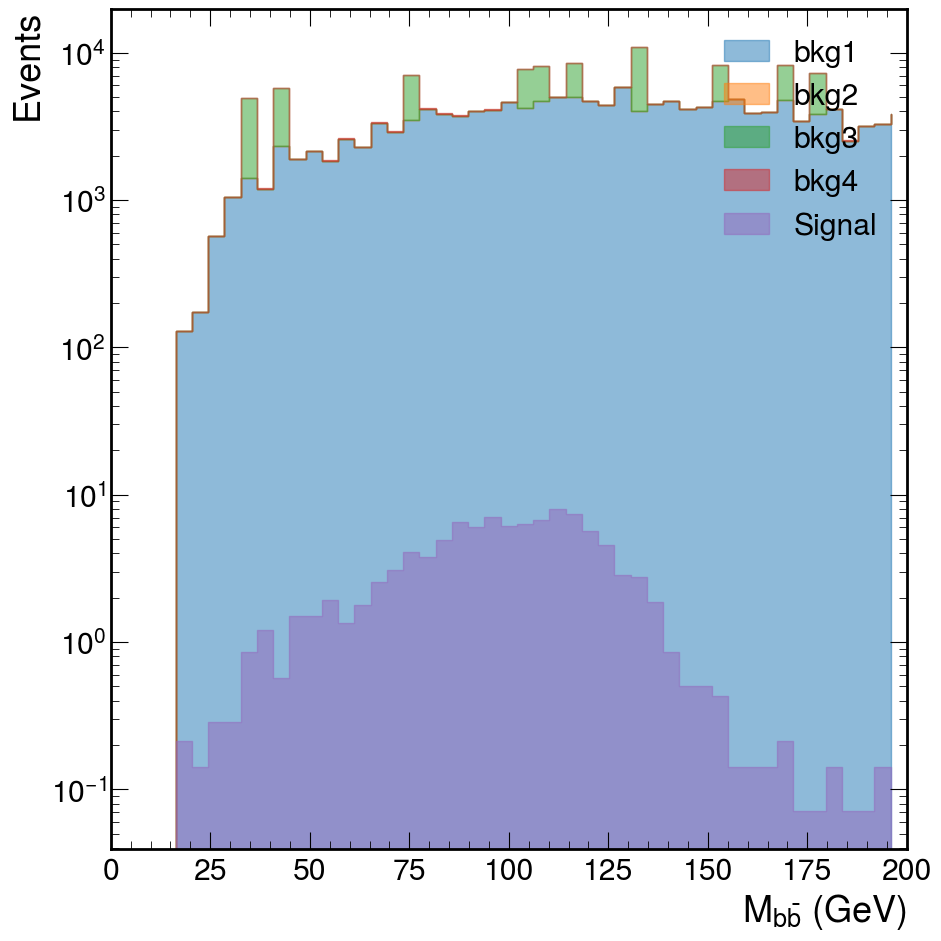

In [12]:
def plot_mass_bb():
    mass_bins = np.linspace(0, 200, 50)
    signal_mass = np.array(signal['BB_mass'])
    bkg1_mass = np.array(bkg1['BB_mass'])
    bkg2_mass = np.array(bkg2['BB_mass'])
    bkg3_mass = np.array(bkg3['BB_mass'])
    bkg4_mass = np.array(bkg4['BB_mass'])
    
    signal_mass_mean, signal_mass_std, signal_mass_bin_c = ht.calculate_hist_stats(
        signal_mass, int(lumi[0])+1, mass_bins)
    bkg1_mass_mean, bkg1_mass_std, bkg1_mass_bin_c = ht.calculate_hist_stats(
        bkg1_mass, int(lumi[1])+1, mass_bins)
    bkg2_mass_mean, bkg2_mass_std, bkg2_mass_bin_c = ht.calculate_hist_stats(
        bkg2_mass, int(lumi[2])+1, mass_bins)
    bkg3_mass_mean, bkg3_mass_std, bkg3_mass_bin_c = ht.calculate_hist_stats(
        bkg3_mass, int(lumi[3])+1, mass_bins)
    bkg4_mass_mean, bkg4_mass_std, bkg4_mass_bin_c = ht.calculate_hist_stats(
        bkg4_mass, int(lumi[4])+1, mass_bins)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    plt.figure(figsize=(10, 10))
    plt.style.use(hep.style.CMS)
    
    # 使用堆叠函数
    plot_stacked_fill(
        bins=mass_bins,
        datasets=[bkg1_mass_mean, bkg2_mass_std, bkg3_mass_mean, bkg4_mass_mean],
        labels=['bkg1', 'bkg2', 'bkg3', 'bkg4'],
        colors=colors[:4],  # 前4个颜色给背景
        signal_data=signal_mass_mean,
        signal_label='Signal'
    )
    
    plt.xlabel("$M_{b\\bar{b}}$ (GeV)")
    plt.ylabel("Events")
    plt.xlim(0, 200)
    plt.yscale('log')
    plt.legend(loc='upper right')

plot_mass_bb()
plt.tight_layout()
plt.savefig("figures/BB_mass.png", dpi=300)

# * # * # * # * # # * # * # * # * # # * # * # * # * # # * # * # * # * # # * # * # * # * # # * # * # * # * # # * # * # * # * # # * # * # * # * # 

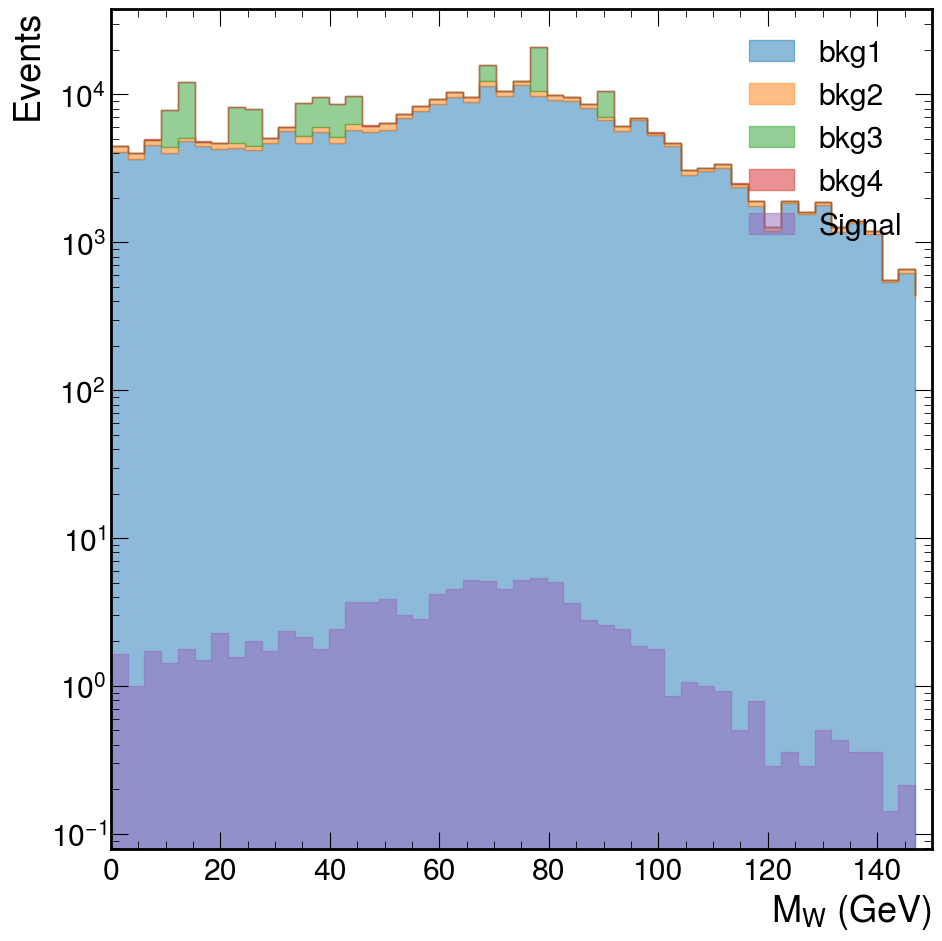

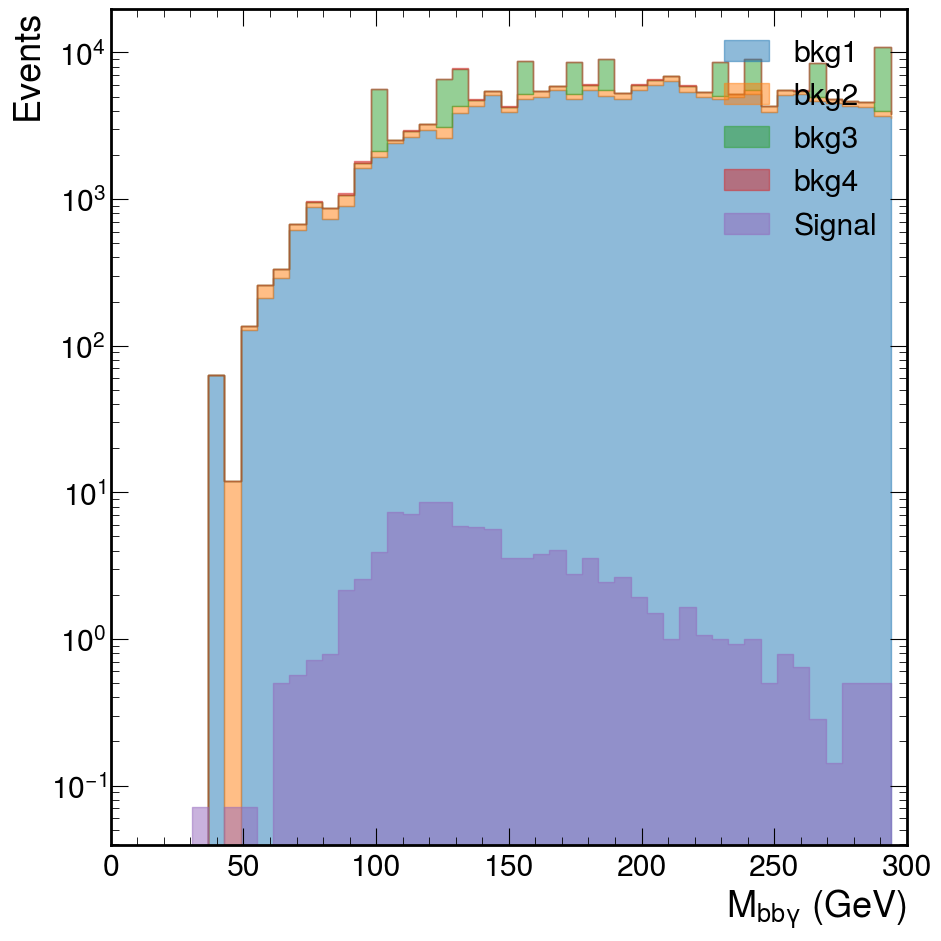

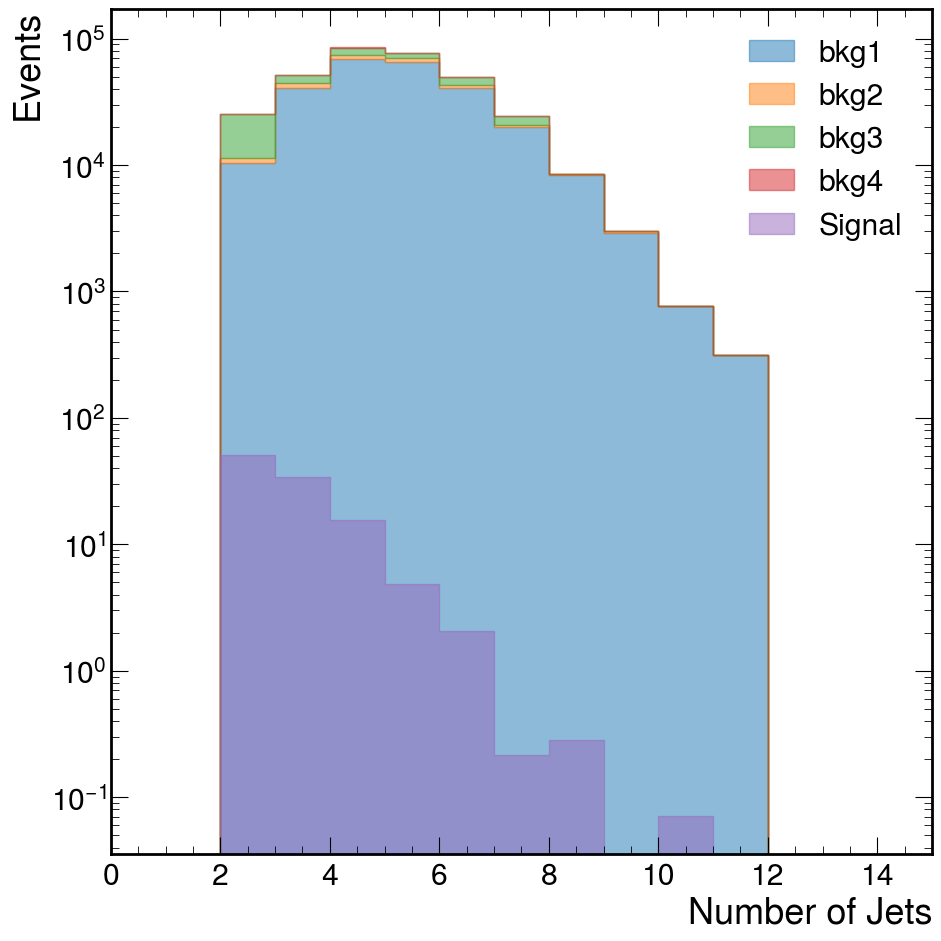

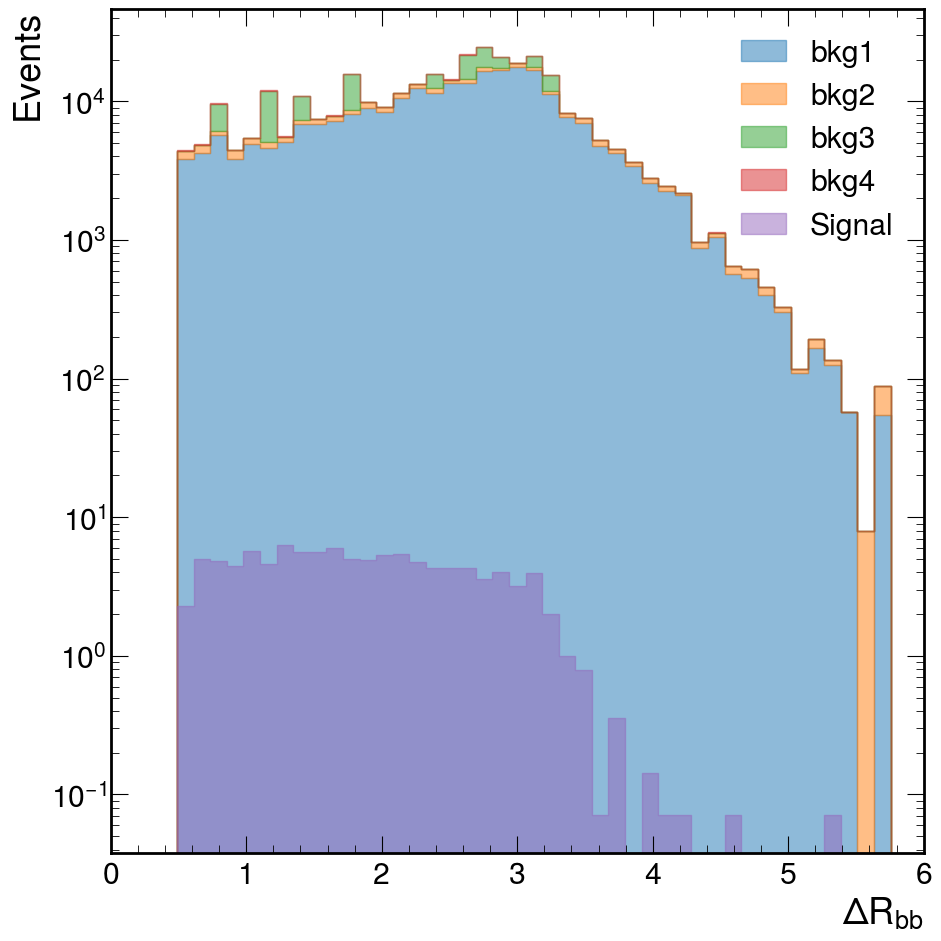

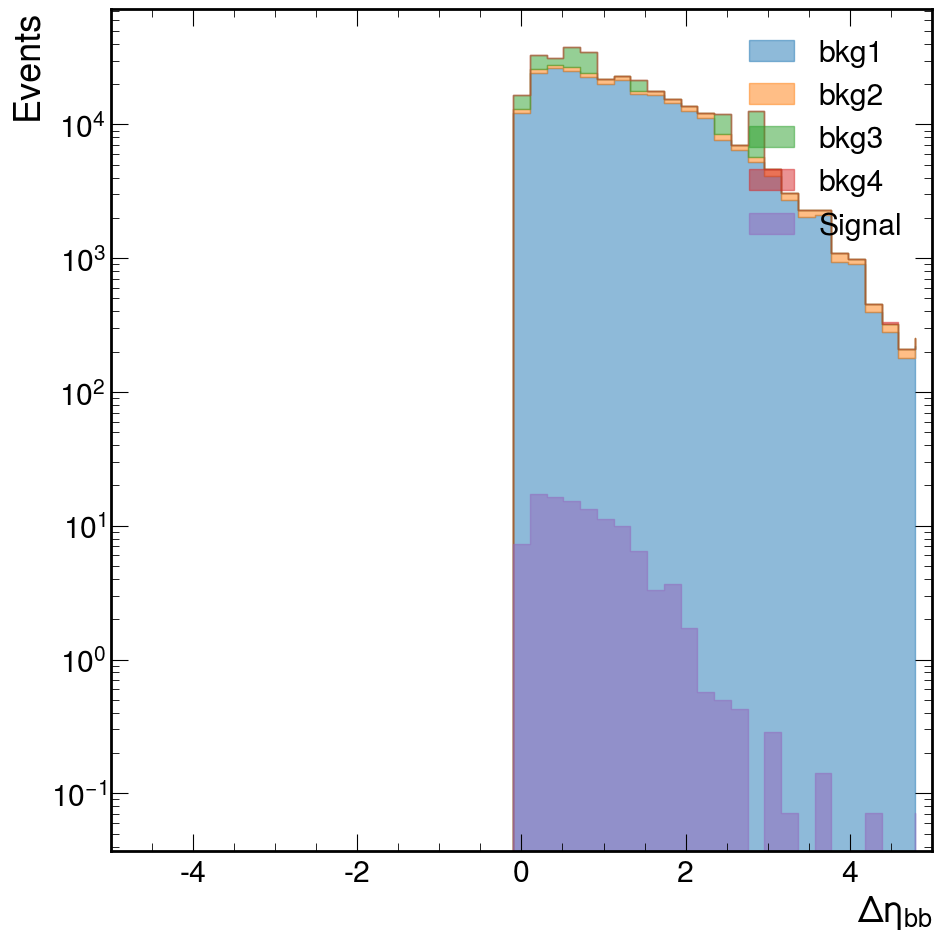

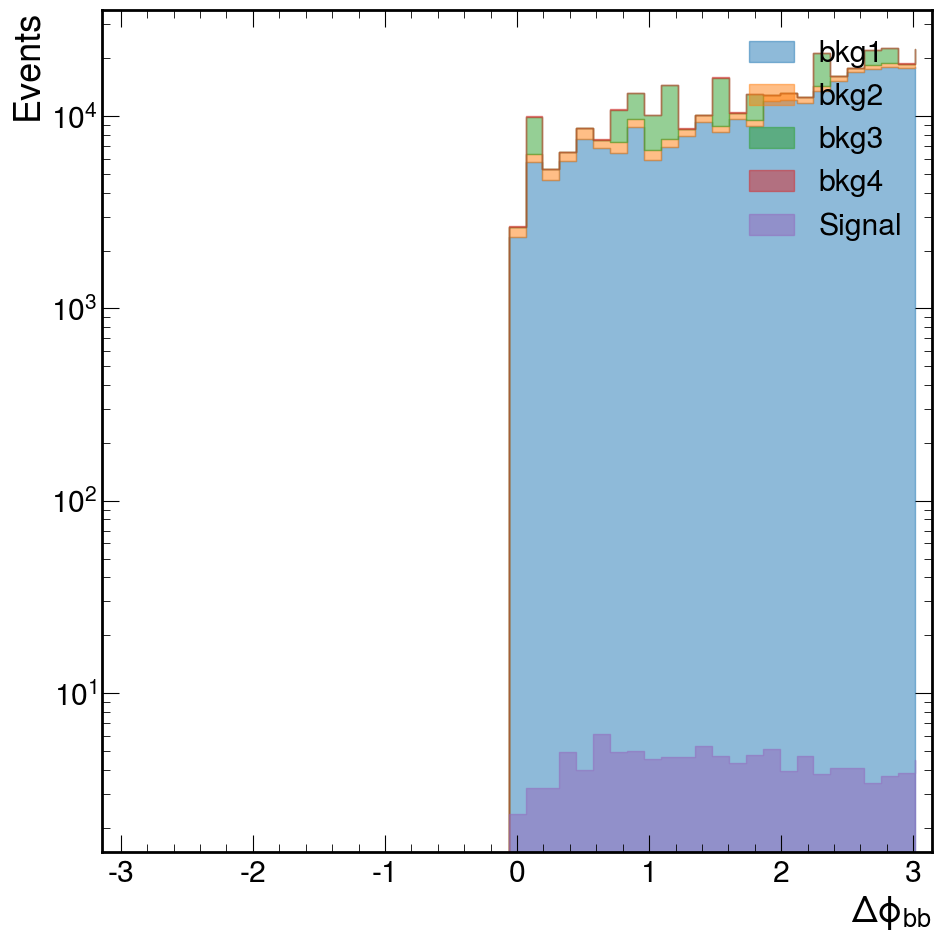

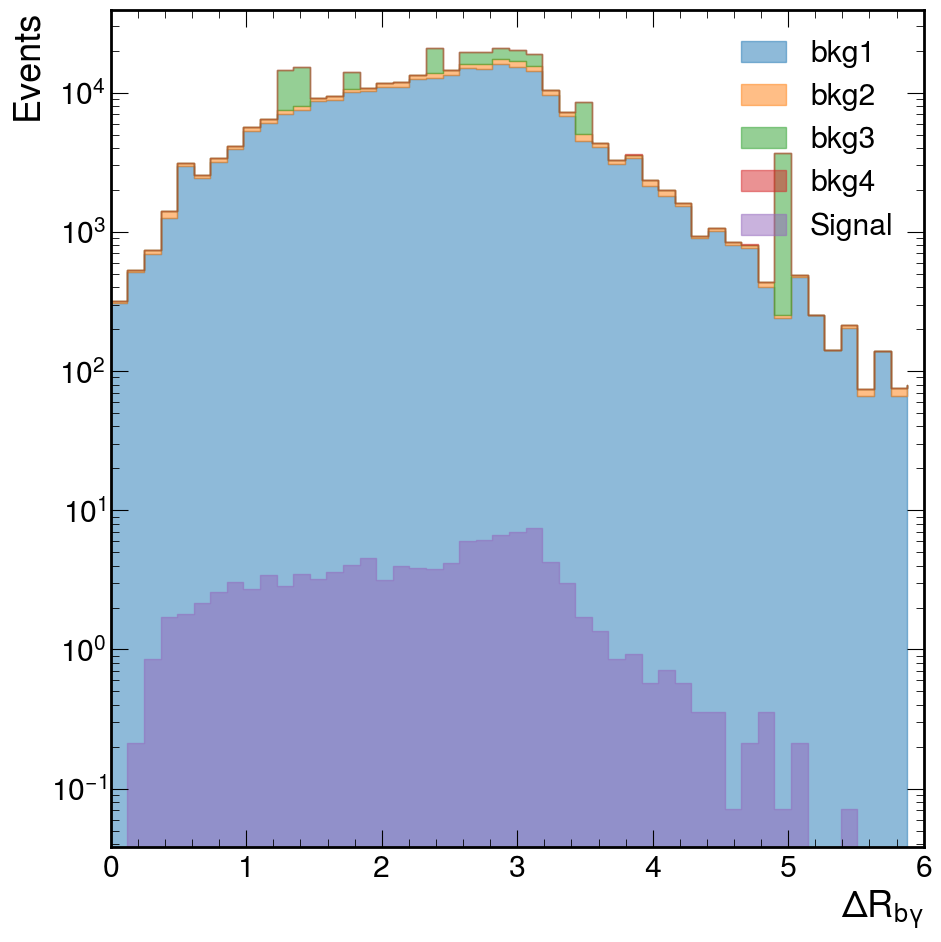

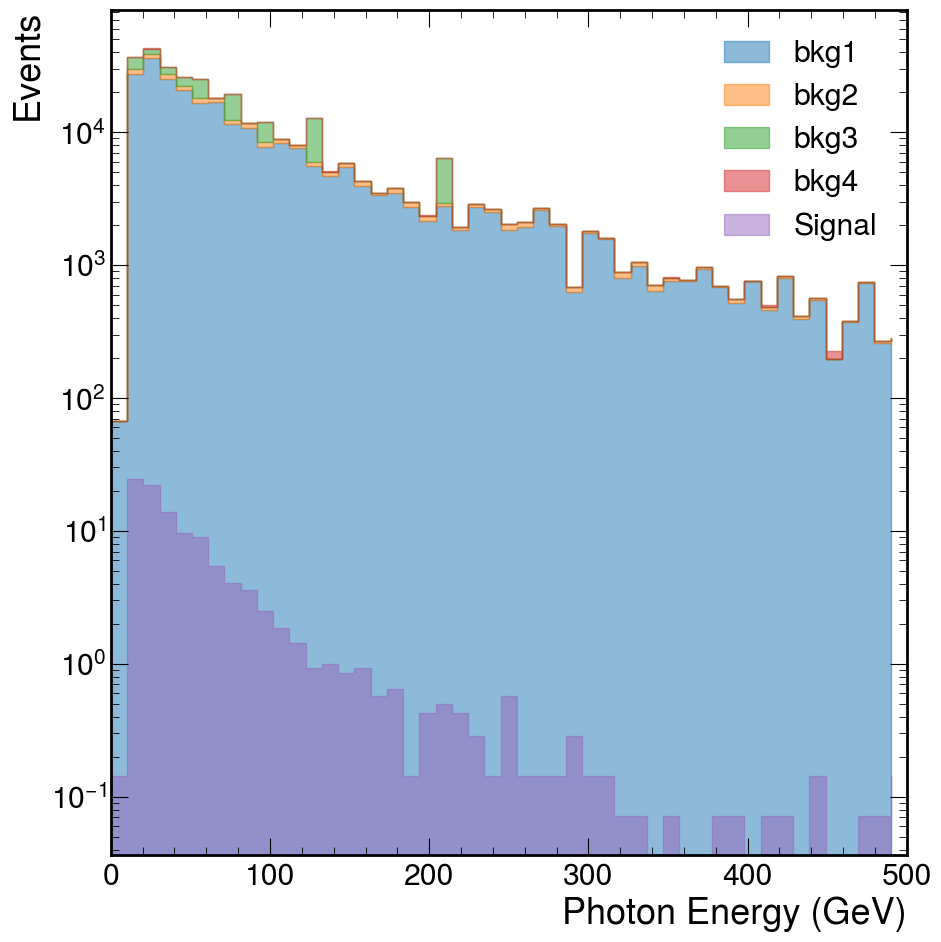

In [13]:
# 仿照plot_mass_bb()创建其他变量的绘图函数

def plot_w_mass():
    """绘制W质量分布"""
    mass_bins = np.linspace(0, 150, 50)  # W玻色子质量范围通常在80GeV左右
    signal_mass = np.array(signal['W_mass'])
    bkg1_mass = np.array(bkg1['W_mass'])
    bkg2_mass = np.array(bkg2['W_mass'])
    bkg3_mass = np.array(bkg3['W_mass'])
    bkg4_mass = np.array(bkg4['W_mass'])
    
    signal_mass_mean, signal_mass_std, signal_mass_bin_c = ht.calculate_hist_stats(
        signal_mass, int(lumi[0])+1, mass_bins)
    bkg1_mass_mean, bkg1_mass_std, bkg1_mass_bin_c = ht.calculate_hist_stats(
        bkg1_mass, int(lumi[1])+1, mass_bins)
    bkg2_mass_mean, bkg2_mass_std, bkg2_mass_bin_c = ht.calculate_hist_stats(
        bkg2_mass, int(lumi[2])+1, mass_bins)
    bkg3_mass_mean, bkg3_mass_std, bkg3_mass_bin_c = ht.calculate_hist_stats(
        bkg3_mass, int(lumi[3])+1, mass_bins)
    bkg4_mass_mean, bkg4_mass_std, bkg4_mass_bin_c = ht.calculate_hist_stats(
        bkg4_mass, int(lumi[4])+1, mass_bins)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    plt.figure(figsize=(10, 10))
    plt.style.use(hep.style.CMS)
    
    plot_stacked_fill(
        bins=mass_bins,
        datasets=[bkg1_mass_mean, bkg2_mass_mean, bkg3_mass_mean, bkg4_mass_mean],
        labels=['bkg1', 'bkg2', 'bkg3', 'bkg4'],
        colors=colors[:4],
        signal_data=signal_mass_mean,
        signal_label='Signal'
    )
    
    plt.xlabel("$M_W$ (GeV)")
    plt.ylabel("Events")
    plt.xlim(0, 150)
    plt.yscale('log')
    plt.legend(loc='upper right')

def plot_bba_mass():
    """绘制BBA质量分布"""
    mass_bins = np.linspace(0, 300, 50)  # BBA质量范围可能更大
    signal_mass = np.array(signal['BBA_mass'])
    bkg1_mass = np.array(bkg1['BBA_mass'])
    bkg2_mass = np.array(bkg2['BBA_mass'])
    bkg3_mass = np.array(bkg3['BBA_mass'])
    bkg4_mass = np.array(bkg4['BBA_mass'])
    
    signal_mass_mean, signal_mass_std, signal_mass_bin_c = ht.calculate_hist_stats(
        signal_mass, int(lumi[0])+1, mass_bins)
    bkg1_mass_mean, bkg1_mass_std, bkg1_mass_bin_c = ht.calculate_hist_stats(
        bkg1_mass, int(lumi[1])+1, mass_bins)
    bkg2_mass_mean, bkg2_mass_std, bkg2_mass_bin_c = ht.calculate_hist_stats(
        bkg2_mass, int(lumi[2])+1, mass_bins)
    bkg3_mass_mean, bkg3_mass_std, bkg3_mass_bin_c = ht.calculate_hist_stats(
        bkg3_mass, int(lumi[3])+1, mass_bins)
    bkg4_mass_mean, bkg4_mass_std, bkg4_mass_bin_c = ht.calculate_hist_stats(
        bkg4_mass, int(lumi[4])+1, mass_bins)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    plt.figure(figsize=(10, 10))
    plt.style.use(hep.style.CMS)
    
    plot_stacked_fill(
        bins=mass_bins,
        datasets=[bkg1_mass_mean, bkg2_mass_mean, bkg3_mass_mean, bkg4_mass_mean],
        labels=['bkg1', 'bkg2', 'bkg3', 'bkg4'],
        colors=colors[:4],
        signal_data=signal_mass_mean,
        signal_label='Signal'
    )
    
    plt.xlabel("$M_{bb\\gamma}$ (GeV)")
    plt.ylabel("Events")
    plt.xlim(0, 300)
    plt.yscale('log')
    plt.legend(loc='upper right')

def plot_njet():
    """绘制喷注数分布"""
    njet_bins = np.linspace(0, 15, 16)  # 喷注数通常是整数，0-15个
    signal_njet = np.array(signal['Njet'])
    bkg1_njet = np.array(bkg1['Njet'])
    bkg2_njet = np.array(bkg2['Njet'])
    bkg3_njet = np.array(bkg3['Njet'])
    bkg4_njet = np.array(bkg4['Njet'])
    
    signal_njet_mean, signal_njet_std, signal_njet_bin_c = ht.calculate_hist_stats(
        signal_njet, int(lumi[0])+1, njet_bins)
    bkg1_njet_mean, bkg1_njet_std, bkg1_njet_bin_c = ht.calculate_hist_stats(
        bkg1_njet, int(lumi[1])+1, njet_bins)
    bkg2_njet_mean, bkg2_njet_std, bkg2_njet_bin_c = ht.calculate_hist_stats(
        bkg2_njet, int(lumi[2])+1, njet_bins)
    bkg3_njet_mean, bkg3_njet_std, bkg3_njet_bin_c = ht.calculate_hist_stats(
        bkg3_njet, int(lumi[3])+1, njet_bins)
    bkg4_njet_mean, bkg4_njet_std, bkg4_njet_bin_c = ht.calculate_hist_stats(
        bkg4_njet, int(lumi[4])+1, njet_bins)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    plt.figure(figsize=(10, 10))
    plt.style.use(hep.style.CMS)
    
    plot_stacked_fill(
        bins=njet_bins,
        datasets=[bkg1_njet_mean, bkg2_njet_mean, bkg3_njet_mean, bkg4_njet_mean],
        labels=['bkg1', 'bkg2', 'bkg3', 'bkg4'],
        colors=colors[:4],
        signal_data=signal_njet_mean,
        signal_label='Signal'
    )
    
    plt.xlabel("Number of Jets")
    plt.ylabel("Events")
    plt.xlim(0, 15)
    plt.yscale('log')
    plt.legend(loc='upper right')

def plot_db_delta_r():
    """绘制dB_delta_r分布"""
    dr_bins = np.linspace(0, 6, 50)  # ΔR通常在0-6范围内
    signal_dr = np.array(signal['dB_delta_r'])
    bkg1_dr = np.array(bkg1['dB_delta_r'])
    bkg2_dr = np.array(bkg2['dB_delta_r'])
    bkg3_dr = np.array(bkg3['dB_delta_r'])
    bkg4_dr = np.array(bkg4['dB_delta_r'])
    
    signal_dr_mean, signal_dr_std, signal_dr_bin_c = ht.calculate_hist_stats(
        signal_dr, int(lumi[0])+1, dr_bins)
    bkg1_dr_mean, bkg1_dr_std, bkg1_dr_bin_c = ht.calculate_hist_stats(
        bkg1_dr, int(lumi[1])+1, dr_bins)
    bkg2_dr_mean, bkg2_dr_std, bkg2_dr_bin_c = ht.calculate_hist_stats(
        bkg2_dr, int(lumi[2])+1, dr_bins)
    bkg3_dr_mean, bkg3_dr_std, bkg3_dr_bin_c = ht.calculate_hist_stats(
        bkg3_dr, int(lumi[3])+1, dr_bins)
    bkg4_dr_mean, bkg4_dr_std, bkg4_dr_bin_c = ht.calculate_hist_stats(
        bkg4_dr, int(lumi[4])+1, dr_bins)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    plt.figure(figsize=(10, 10))
    plt.style.use(hep.style.CMS)
    
    plot_stacked_fill(
        bins=dr_bins,
        datasets=[bkg1_dr_mean, bkg2_dr_mean, bkg3_dr_mean, bkg4_dr_mean],
        labels=['bkg1', 'bkg2', 'bkg3', 'bkg4'],
        colors=colors[:4],
        signal_data=signal_dr_mean,
        signal_label='Signal'
    )
    
    plt.xlabel("$\\Delta R_{bb}$")
    plt.ylabel("Events")
    plt.xlim(0, 6)
    plt.yscale('log')
    plt.legend(loc='upper right')

def plot_db_delta_eta():
    """绘制dB_delta_eta分布"""
    deta_bins = np.linspace(-5, 5, 50)  # Δη通常在-5到5范围内
    signal_deta = np.array(signal['dB_delta_eta'])
    bkg1_deta = np.array(bkg1['dB_delta_eta'])
    bkg2_deta = np.array(bkg2['dB_delta_eta'])
    bkg3_deta = np.array(bkg3['dB_delta_eta'])
    bkg4_deta = np.array(bkg4['dB_delta_eta'])
    
    signal_deta_mean, signal_deta_std, signal_deta_bin_c = ht.calculate_hist_stats(
        signal_deta, int(lumi[0])+1, deta_bins)
    bkg1_deta_mean, bkg1_deta_std, bkg1_deta_bin_c = ht.calculate_hist_stats(
        bkg1_deta, int(lumi[1])+1, deta_bins)
    bkg2_deta_mean, bkg2_deta_std, bkg2_deta_bin_c = ht.calculate_hist_stats(
        bkg2_deta, int(lumi[2])+1, deta_bins)
    bkg3_deta_mean, bkg3_deta_std, bkg3_deta_bin_c = ht.calculate_hist_stats(
        bkg3_deta, int(lumi[3])+1, deta_bins)
    bkg4_deta_mean, bkg4_deta_std, bkg4_deta_bin_c = ht.calculate_hist_stats(
        bkg4_deta, int(lumi[4])+1, deta_bins)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    plt.figure(figsize=(10, 10))
    plt.style.use(hep.style.CMS)
    
    plot_stacked_fill(
        bins=deta_bins,
        datasets=[bkg1_deta_mean, bkg2_deta_mean, bkg3_deta_mean, bkg4_deta_mean],
        labels=['bkg1', 'bkg2', 'bkg3', 'bkg4'],
        colors=colors[:4],
        signal_data=signal_deta_mean,
        signal_label='Signal'
    )
    
    plt.xlabel("$\\Delta \\eta_{bb}$")
    plt.ylabel("Events")
    plt.xlim(-5, 5)
    plt.yscale('log')
    plt.legend(loc='upper right')

def plot_db_delta_phi():
    """绘制dB_delta_phi分布"""
    dphi_bins = np.linspace(-np.pi, np.pi, 50)  # Δφ通常在-π到π范围内
    signal_dphi = np.array(signal['dB_delta_phi'])
    bkg1_dphi = np.array(bkg1['dB_delta_phi'])
    bkg2_dphi = np.array(bkg2['dB_delta_phi'])
    bkg3_dphi = np.array(bkg3['dB_delta_phi'])
    bkg4_dphi = np.array(bkg4['dB_delta_phi'])
    
    signal_dphi_mean, signal_dphi_std, signal_dphi_bin_c = ht.calculate_hist_stats(
        signal_dphi, int(lumi[0])+1, dphi_bins)
    bkg1_dphi_mean, bkg1_dphi_std, bkg1_dphi_bin_c = ht.calculate_hist_stats(
        bkg1_dphi, int(lumi[1])+1, dphi_bins)
    bkg2_dphi_mean, bkg2_dphi_std, bkg2_dphi_bin_c = ht.calculate_hist_stats(
        bkg2_dphi, int(lumi[2])+1, dphi_bins)
    bkg3_dphi_mean, bkg3_dphi_std, bkg3_dphi_bin_c = ht.calculate_hist_stats(
        bkg3_dphi, int(lumi[3])+1, dphi_bins)
    bkg4_dphi_mean, bkg4_dphi_std, bkg4_dphi_bin_c = ht.calculate_hist_stats(
        bkg4_dphi, int(lumi[4])+1, dphi_bins)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    plt.figure(figsize=(10, 10))
    plt.style.use(hep.style.CMS)
    
    plot_stacked_fill(
        bins=dphi_bins,
        datasets=[bkg1_dphi_mean, bkg2_dphi_mean, bkg3_dphi_mean, bkg4_dphi_mean],
        labels=['bkg1', 'bkg2', 'bkg3', 'bkg4'],
        colors=colors[:4],
        signal_data=signal_dphi_mean,
        signal_label='Signal'
    )
    
    plt.xlabel("$\\Delta \\phi_{bb}$")
    plt.ylabel("Events")
    plt.xlim(-np.pi, np.pi)
    plt.yscale('log')
    plt.legend(loc='upper right')

def plot_bp_delta_r():
    """绘制bP_delta_r分布"""
    dr_bins = np.linspace(0, 6, 50)  # ΔR通常在0-6范围内
    signal_dr = np.array(signal['bP_delta_r'])
    bkg1_dr = np.array(bkg1['bP_delta_r'])
    bkg2_dr = np.array(bkg2['bP_delta_r'])
    bkg3_dr = np.array(bkg3['bP_delta_r'])
    bkg4_dr = np.array(bkg4['bP_delta_r'])
    
    signal_dr_mean, signal_dr_std, signal_dr_bin_c = ht.calculate_hist_stats(
        signal_dr, int(lumi[0])+1, dr_bins)
    bkg1_dr_mean, bkg1_dr_std, bkg1_dr_bin_c = ht.calculate_hist_stats(
        bkg1_dr, int(lumi[1])+1, dr_bins)
    bkg2_dr_mean, bkg2_dr_std, bkg2_dr_bin_c = ht.calculate_hist_stats(
        bkg2_dr, int(lumi[2])+1, dr_bins)
    bkg3_dr_mean, bkg3_dr_std, bkg3_dr_bin_c = ht.calculate_hist_stats(
        bkg3_dr, int(lumi[3])+1, dr_bins)
    bkg4_dr_mean, bkg4_dr_std, bkg4_dr_bin_c = ht.calculate_hist_stats(
        bkg4_dr, int(lumi[4])+1, dr_bins)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    plt.figure(figsize=(10, 10))
    plt.style.use(hep.style.CMS)
    
    plot_stacked_fill(
        bins=dr_bins,
        datasets=[bkg1_dr_mean, bkg2_dr_mean, bkg3_dr_mean, bkg4_dr_mean],
        labels=['bkg1', 'bkg2', 'bkg3', 'bkg4'],
        colors=colors[:4],
        signal_data=signal_dr_mean,
        signal_label='Signal'
    )
    
    plt.xlabel("$\\Delta R_{b\\gamma}$")
    plt.ylabel("Events")
    plt.xlim(0, 6)
    plt.yscale('log')
    plt.legend(loc='upper right')

def plot_photon_energy():
    """绘制光子能量分布"""
    energy_bins = np.linspace(0, 500, 50)  # 光子能量范围，根据实际情况调整
    signal_energy = np.array(signal['photon_energy'])
    bkg1_energy = np.array(bkg1['photon_energy'])
    bkg2_energy = np.array(bkg2['photon_energy'])
    bkg3_energy = np.array(bkg3['photon_energy'])
    bkg4_energy = np.array(bkg4['photon_energy'])
    
    signal_energy_mean, signal_energy_std, signal_energy_bin_c = ht.calculate_hist_stats(
        signal_energy, int(lumi[0])+1, energy_bins)
    bkg1_energy_mean, bkg1_energy_std, bkg1_energy_bin_c = ht.calculate_hist_stats(
        bkg1_energy, int(lumi[1])+1, energy_bins)
    bkg2_energy_mean, bkg2_energy_std, bkg2_energy_bin_c = ht.calculate_hist_stats(
        bkg2_energy, int(lumi[2])+1, energy_bins)
    bkg3_energy_mean, bkg3_energy_std, bkg3_energy_bin_c = ht.calculate_hist_stats(
        bkg3_energy, int(lumi[3])+1, energy_bins)
    bkg4_energy_mean, bkg4_energy_std, bkg4_energy_bin_c = ht.calculate_hist_stats(
        bkg4_energy, int(lumi[4])+1, energy_bins)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    plt.figure(figsize=(10, 10))
    plt.style.use(hep.style.CMS)
    
    plot_stacked_fill(
        bins=energy_bins,
        datasets=[bkg1_energy_mean, bkg2_energy_mean, bkg3_energy_mean, bkg4_energy_mean],
        labels=['bkg1', 'bkg2', 'bkg3', 'bkg4'],
        colors=colors[:4],
        signal_data=signal_energy_mean,
        signal_label='Signal'
    )
    
    plt.xlabel("Photon Energy (GeV)")
    plt.ylabel("Events")
    plt.xlim(0, 500)
    plt.yscale('log')
    plt.legend(loc='upper right')
plot_w_mass()
plt.tight_layout()
plt.savefig("figures/W_mass.png", dpi=300)
plot_bba_mass()
plt.tight_layout()
plt.savefig("figures/BBA_mass.png", dpi=300)
plot_njet()
plt.tight_layout()
plt.savefig("figures/Njet.png", dpi=300)
plot_db_delta_r() 
plt.tight_layout()
plt.savefig("figures/dB_delta_r.png", dpi=300)
plot_db_delta_eta()
plt.tight_layout()
plt.savefig("figures/dB_delta_eta.png", dpi=300)
plot_db_delta_phi()
plt.tight_layout()
plt.savefig("figures/dB_delta_phi.png", dpi=300)
plot_bp_delta_r()
plt.tight_layout()
plt.savefig("figures/bP_delta_r.png", dpi=300)
plot_photon_energy()
plt.tight_layout()
plt.savefig("figures/photon_energy.png", dpi=300)